# Traffic Prediction

**Caleb Pitts | Oct 2019**

## Data Source

Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume. Observations made between Feb 10, 2012 and Sep 30, 2018.

**holiday**             : Categorical US National holidays plus regional holiday, Minnesota State Fair <br>
**temp**                : Numeric Average temp in kelvin <br>
**rain_1h**             : Numeric Amount in mm of rain that occurred in the hour <br>
**snow_1h**             : Numeric Amount in mm of snow that occurred in the hour <br>
**clouds_all**          : Numeric Percentage of cloud cover <br>
**weather_main**        : Categorical Short textual description of the current weather <br>
**weather_description** : Categorical Longer textual description of the current weather <br>
**date_time**           : DateTime Hour of the data collected in local CST time <br>
**traffic_volume**      : Numeric Hourly I-94 ATR 301 reported westbound traffic volume<br>

http://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

**Packages Used**

In [1]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np

**Reading in the data**

In [2]:
df = pd.read_csv("/Users/CalebPitts/Documents/Files/Projects/TrafficVolume/interstate_traffic_data.csv")

In [3]:
df.shape

(48204, 9)

In [4]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


## Initial Data Cleansing

In [5]:
df["date"] = pd.to_datetime(df["date_time"])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 10 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null object
traffic_volume         48204 non-null int64
date                   48204 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 3.7+ MB


No null values in any of the rows. 

In [7]:
# converting holiday to binary value. 1 if holiday, 0 otherwise
df["holiday"] = df["holiday"].apply(lambda x: 0 if x == "None" else 1)
df["holiday"].value_counts()

0    48143
1       61
Name: holiday, dtype: int64

**Handling Duplicates**

In [8]:
dup_aggs = {"holiday": "sum",
            "temp": "mean",
            "rain_1h": "mean",
            "snow_1h": "mean", 
            "clouds_all": "mean",
            "weather_main": "first",
            "weather_description": "first",
            "traffic_volume": "mean"}

In [9]:
# selects all duplicated observations
dup_obs = df[df["date"].duplicated(keep=False)]

# groups duplicated observations and records info based on 'aggs' dictionary
dup_info = dup_obs.groupby("date").agg(dup_aggs).reset_index() 

# selects all non-duplicated/unique observations
non_dups = df[~df["date_time"].duplicated(keep=False)]

# recombines duplicated info with unique info
dfg = non_dups.append(dup_info).sort_values("date_time")  

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


**Determing time series quality**

In [10]:
# determining whether there are any irregular gaps in time series observations
def get_timestamp_diffs(df):
    timestamp_diffs = df["date"].diff()
    print(timestamp_diffs.value_counts())

In [11]:
get_timestamp_diffs(dfg)

0 days 01:00:00      35333
0 days 02:00:00       2735
0 days 03:00:00        610
0 days 04:00:00        330
0 days 05:00:00        189
0 days 06:00:00        156
0 days 07:00:00        104
0 days 08:00:00        101
0 days 10:00:00         83
0 days 09:00:00         67
0 days 11:00:00         61
0 days 12:00:00         54
0 days 13:00:00         42
0 days 16:00:00         41
0 days 14:00:00         40
0 days 21:00:00         34
0 days 15:00:00         31
0 days 19:00:00         28
0 days 20:00:00         22
0 days 17:00:00         22
0 days 22:00:00         21
1 days 00:00:00         20
0 days 18:00:00         17
1 days 01:00:00         12
1 days 06:00:00         12
1 days 23:00:00         11
1 days 02:00:00         11
1 days 09:00:00         11
0 days 23:00:00         10
1 days 19:00:00          9
                     ...  
3 days 19:00:00          1
3 days 00:00:00          1
10 days 08:00:00         1
5 days 10:00:00          1
14 days 20:00:00         1
9 days 16:00:00          1
6

Looks like most times are 1 hour apart but there are some issues with missing timestamps and a large gap of 307 days somewhere.

In [12]:
# filling gaps with the previous traffic volume observation
# making data hourly hence the term data frame hourly (dfh)
dfh = dfg.set_index("date").resample("H").first().bfill()

In [13]:
get_timestamp_diffs(dfh.reset_index())  # everything is hourly now

01:00:00    52550
Name: date, dtype: int64


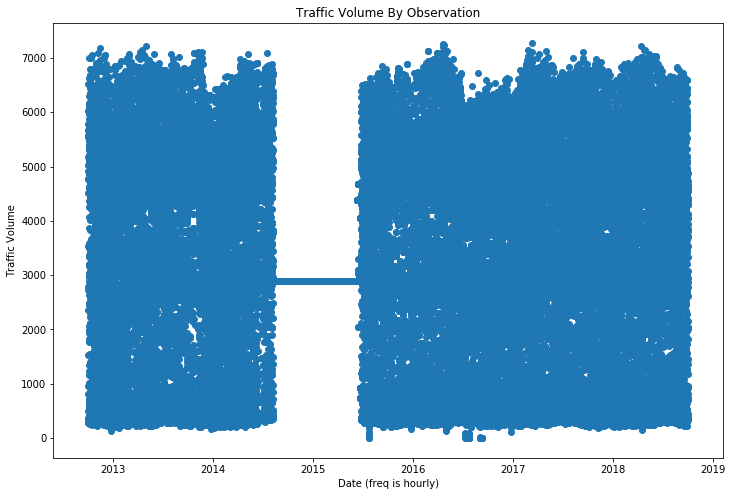

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(dfh.index, dfh.traffic_volume)
plt.title("Traffic Volume By Observation")
plt.ylabel("Traffic Volume")
plt.xlabel("Date (freq is hourly)")
plt.show()

We have missing data around 2015 where there is a gap of 307 days. To compensate this, I will select data after this gap. Later, I plan to join this data and close the gap so that my model also trains on 2013 and 2014 data. 

In [15]:
dfh = dfh.loc['2015-06-26':]

In [16]:
dfh.index.freq = 'H'

In [17]:
dfh.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28632 entries, 2015-06-26 00:00:00 to 2018-09-30 23:00:00
Freq: H
Data columns (total 9 columns):
clouds_all             28632 non-null float64
date_time              28632 non-null object
holiday                28632 non-null float64
rain_1h                28632 non-null float64
snow_1h                28632 non-null float64
temp                   28632 non-null float64
traffic_volume         28632 non-null float64
weather_description    28632 non-null object
weather_main           28632 non-null object
dtypes: float64(6), object(3)
memory usage: 2.2+ MB


In [18]:
dfh.index=dfh.index.rename("date_time")

**Getting observations by day**

In [19]:
day_aggs = {"holiday": "max",
            "temp": "mean",
            "rain_1h": "sum",
            "snow_1h": "sum", 
            "clouds_all": "mean",
            "weather_main": ', '.join,
            "weather_description": ', '.join,
            "traffic_volume": "sum"}

In [20]:
# getting volumes by day as well
dfd = dfh.resample("D").agg(day_aggs)

## Initial Data Exploration

In [21]:
dfd["traffic_volume"].describe()

count      1193.000000
mean      79535.240570
std       13541.957861
min        6654.000000
25%       69571.000000
50%       84161.000000
75%       89201.000000
max      142968.000000
Name: traffic_volume, dtype: float64

Average traffic volume in a given hour along the interstate is about **3260 cars.**

In [22]:
# grouping data by hour in the day 1-24 to see what an average day looks like
day_hourly_avgs = dfh.groupby(dfh.index.hour).mean()

In [23]:
day_hourly_avgs

,clouds_all,holiday,rain_1h,snow_1h,temp,traffic_volume
date_time,,,,,,
0,34.088852,0.036044,0.060495,0.000159,281.284924,870.401509
1,34.055323,0.000000,0.059430,0.000184,280.842548,545.496228
2,34.120704,0.000000,0.060335,0.000067,280.448808,429.167645
3,33.587594,0.000000,0.100880,0.000067,280.108915,442.672255
4,34.814753,0.000000,0.063294,0.000042,279.802577,829.886002
5,35.904443,0.000000,0.067921,0.000042,279.538432,2325.279128
6,37.263202,0.000000,0.077661,0.000042,279.313137,4209.865046
7,42.827326,0.000000,0.082582,0.000042,279.372355,4757.607712
8,44.962280,0.000000,0.051106,0.000126,280.035076,4585.041073


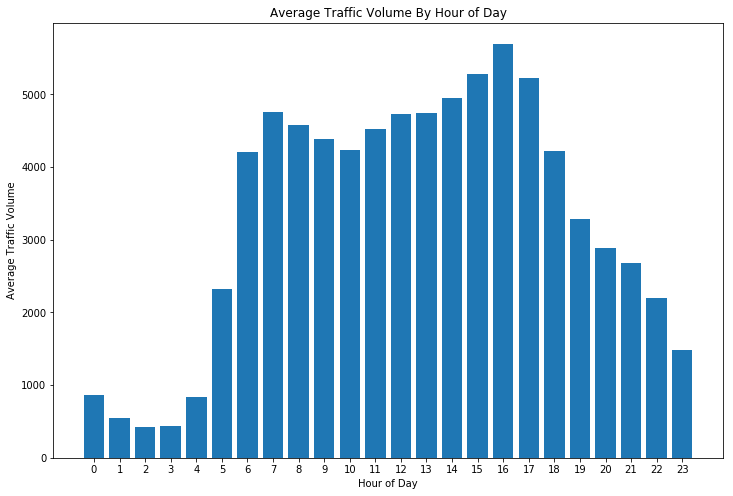

In [24]:
plt.figure(figsize=(12,8))
plt.bar(day_hourly_avgs.index, day_hourly_avgs["traffic_volume"])
plt.xticks([hour for hour in range(24)])
plt.title("Average Traffic Volume By Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Traffic Volume");

The bar chart gives an expected volume distribution with the lower volumes being night time 12-3AM and the peak volumes being 6-10AM and 3-5PM.

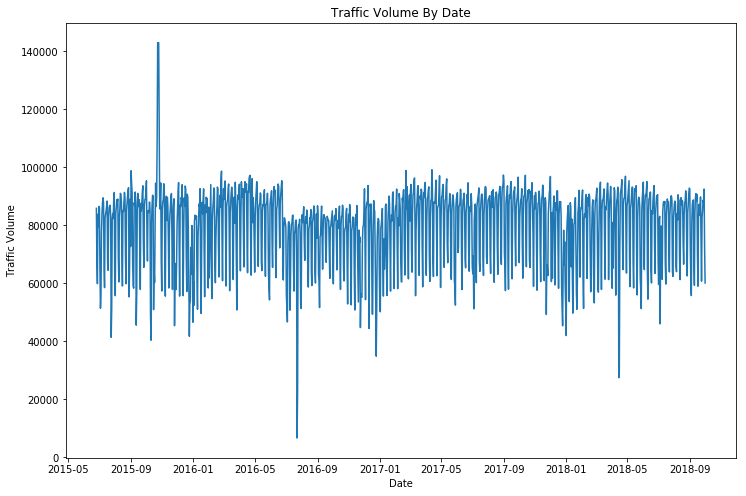

In [25]:
plt.figure(figsize=(12,8))
plt.plot(dfd.index, dfd["traffic_volume"])
plt.title("Traffic Volume By Date")
plt.xlabel("Date")
plt.ylabel("Traffic Volume");

Seems a little busy. Let's clean this up by creating a moving average and exploring the apparent gap in 2014/2015 data.

In [26]:
dfd["traffic_volume_rolling28"] = dfd["traffic_volume"].rolling(window=28).mean()

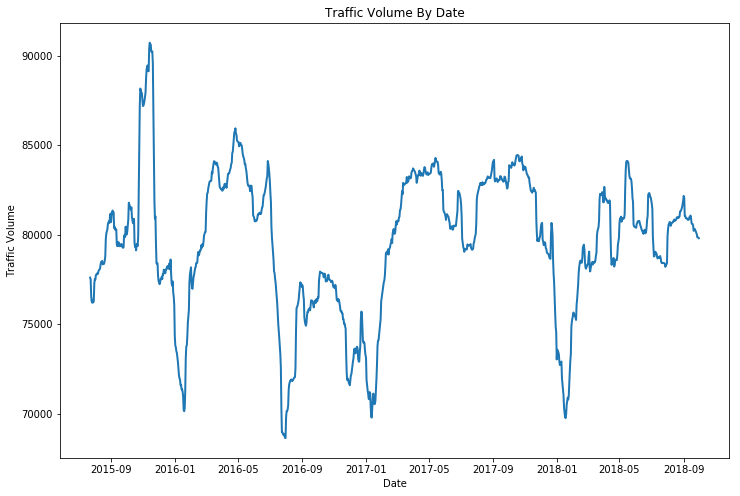

In [27]:
plt.figure(figsize=(12,8))
plt.plot(dfd.index, dfd["traffic_volume_rolling28"], lw=2)
plt.title("Traffic Volume By Date")
plt.xlabel("Date")
plt.ylabel("Traffic Volume");

## ARIMA(p,q,d) Order Exploration

I am going to start to try forecasting volumes by day first. So lets explore autocorrelations of 'dfd' or daily volumes.

In [28]:
dfd.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,traffic_volume_rolling28
date_time,,,,,,,,,
2015-06-26,0.0,294.062083,2.12,0.0,12.666667,"Clear, Clear, Clear, Clear, Clear, Clear, Clea...","sky is clear, sky is clear, sky is clear, sky ...",85850.0,NaN
2015-06-27,0.0,294.385833,3.46,0.0,5.708333,"Clear, Clear, Clear, Rain, Mist, Mist, Mist, M...","sky is clear, sky is clear, sky is clear, ligh...",67193.0,NaN
2015-06-28,0.0,293.559583,30.43,0.0,64.000000,"Rain, Rain, Rain, Drizzle, Rain, Rain, Rain, D...","moderate rain, moderate rain, heavy intensity ...",59865.0,NaN
2015-06-29,0.0,294.382917,15.62,0.0,7.333333,"Mist, Mist, Mist, Mist, Fog, Fog, Fog, Rain, R...","mist, mist, mist, mist, fog, fog, fog, light r...",83855.0,NaN
2015-06-30,0.0,292.205417,0.55,0.0,15.291667,"Mist, Mist, Mist, Mist, Rain, Haze, Mist, Rain...","mist, mist, mist, mist, light rain, haze, mist...",79556.0,NaN


In [29]:
dfd.index.freq = "D"

Let's first test fot stationarity

In [30]:
result = adfuller(dfd["traffic_volume"])
result[1]  # extracts the p-value

2.2261134189871453e-05

The p-value is very close to zero, which effectively says that I can reject the null hypothesis and conclude that I have evidence that says this dataset is stationary. Thus, I do not need to have an integrated component. (q=0)

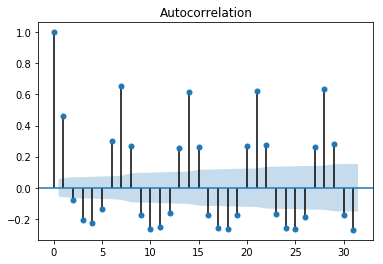

In [31]:
plot_acf(dfd["traffic_volume"]);

This ACF plot shows signifigant lags, but I am going to stop at 5, thus (d=5)

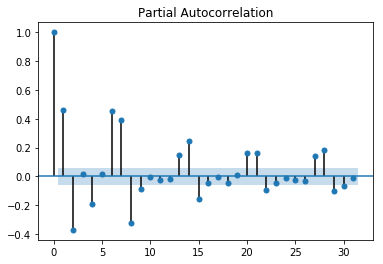

In [32]:
plot_pacf(dfd["traffic_volume"]);

This PACF plot shows how observations are correlated with earlier observations. In this case, I am seeing that 2 lags are signifigantly correlated (p=2) 

## ARIMA Model

In [33]:
result = seasonal_decompose(dfd["traffic_volume"], model='add')

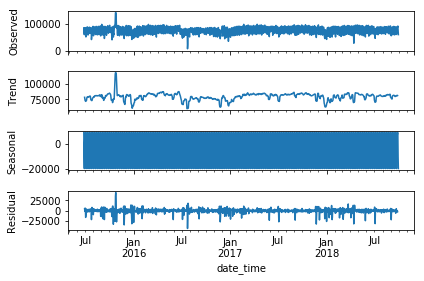

In [34]:
result.plot();

(16801, 16832)

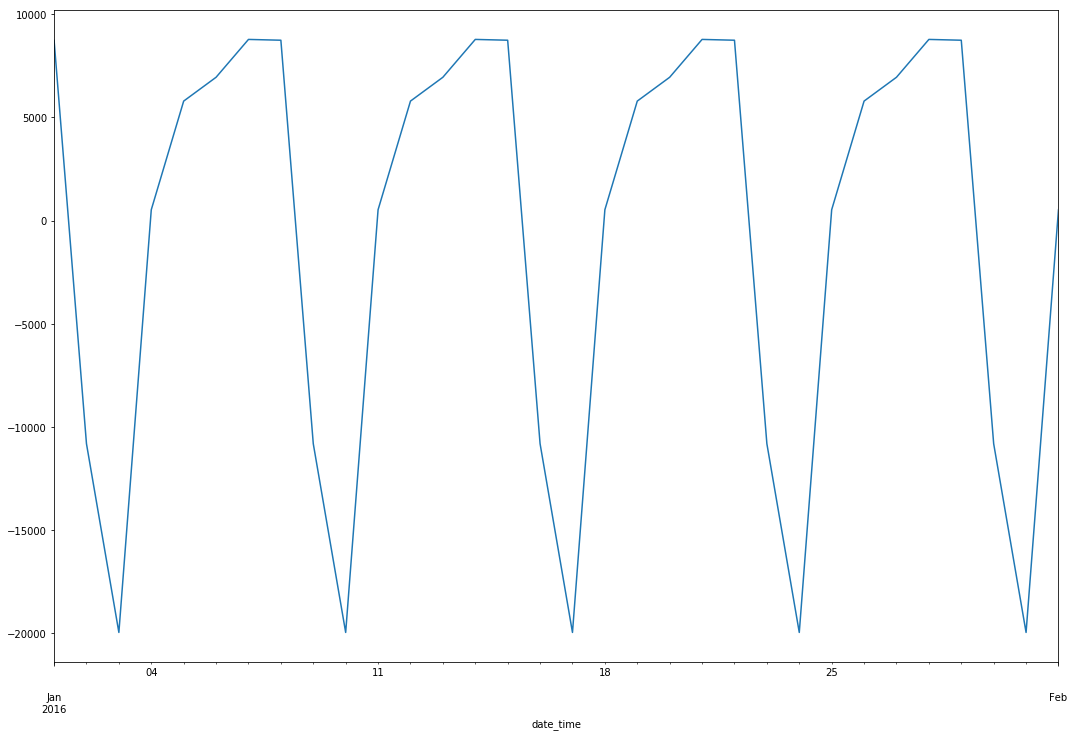

In [35]:
result.seasonal.plot(figsize=(18,12))
plt.xlim("2016-01-01", "2016-02-01")

I am seeing a weekly seasonal trend due to the 4 cycles in each month and a dip occuring every 7 days. Thus, I will treat 1 week or 7 observations as a season/cycle when I fit a SARIMA and SARIMAX model.

**Train/Test Split**

My goal is to predict trafic volumes n amount of days into the future. So I will write a function that does this using input n.

In [36]:
def traffic_volume_forecast(full_data, n_steps, freq):
    '''
    @Description
    Trains, tests, and forecasts traffic volumes based on previous traffic data.
    
    @Paremeters
    data: Time series with traffic volumes to train on.
    n_steps: Indicates how to split the train/test groups and how far you want to forecast into the future.
    freq: Frequency of each time series step/observation
    
    @Returns
    forecast: list of forecasted values with length of 'n_steps'
    test: data subset used to compare predicted values with untrained actual values
    preds: predicted values generating from training group
    auto_result.order: order that the ARIMA model was fit with
    metrics: RMSE, MSE, MAPE
    '''
    # warnings.filterwarnings("ignore")
    
    # train/test split
    data = full_data["traffic_volume"]
    train = data[:len(data)-n_steps]
    test = data[len(data)-n_steps:]  
    
    # grid search
    auto_result = auto_arima(train)
    
    # fit model
    mod = ARIMA(train, order = auto_result.order).fit()
    
    # get predictions
    preds = mod.forecast(steps=n_steps)[0]
    
    # evaluate model
    metrics = get_metrics(test.values, preds)
    
    # forecast future observations
    forecast = generate_forecast(data, auto_result.order, n_steps, freq)
    
    return (forecast, test, preds, auto_result.order, metrics)

**Here are the guts of the function**

In [37]:
data = dfd
n_steps = 90

In [38]:
data = dfd["traffic_volume"]
train = data[:len(data)-n_steps]
test = data[len(data)-n_steps:]  

In [39]:
auto_result = auto_arima(train)

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [40]:
mod = ARIMA(train, order = auto_result.order).fit()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [41]:
mod.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                 1103
Model:                     ARMA(3, 3)   Log Likelihood              -11665.694
Method:                       css-mle   S.D. of innovations           9440.723
Date:                Sun, 06 Oct 2019   AIC                          23347.387
Time:                        22:45:42   BIC                          23387.434
Sample:                    06-26-2015   HQIC                         23362.535
                         - 07-02-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.949e+04    391.122    203.247      0.000    7.87e+04    8.03e+04
ar.L1.traffic_volume     1.0758        nan        nan        nan         nan         nan
ar.L2.traffic_volume    -0.7859        nan        nan        nan         nan         nan
ar.L3.traffic_volume    -0.1717        nan        nan        nan         nan         nan
ma.L1.traffic_volume    -0.6358      0.024    -26.875      0.000      -0.682      -0.589
ma.L2.traffic_volume     0.2411      0.030      8.129      0.000       0.183       0.299
ma.L3.traffic_volume     0.6082      0.024     25.455      0.000       0.561       0.655
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6237           -0.7817j            1.0000           -0.1428
AR.2            0.6237           +0.7817j            1.0000            0.1428
AR.3           -5.8256           -0.0000j            5.8256           -0.5000
MA.1            0.6230           -0.7829j            1.0005           -0.1430
MA.2            0.6230           +0.7829j            1.0005            0.1430
MA.3           -1.6424           -0.0000j            1.6424           -0.5000
-----------------------------------------------------------------------------
"""

In [42]:
preds = mod.forecast(steps=90)[0]

In [43]:
def plot_prediction_vs_testing(test, n_steps, preds):
    '''
    '''
    plt.figure(figsize=(14,10))
    plt.plot(test, label="actual")
    plt.plot(test.index, preds, c='red', label="predicted")
    plt.legend()
    plt.title("{}-Day Prediction vs Testing Actuals".format(n_steps))
    plt.show()

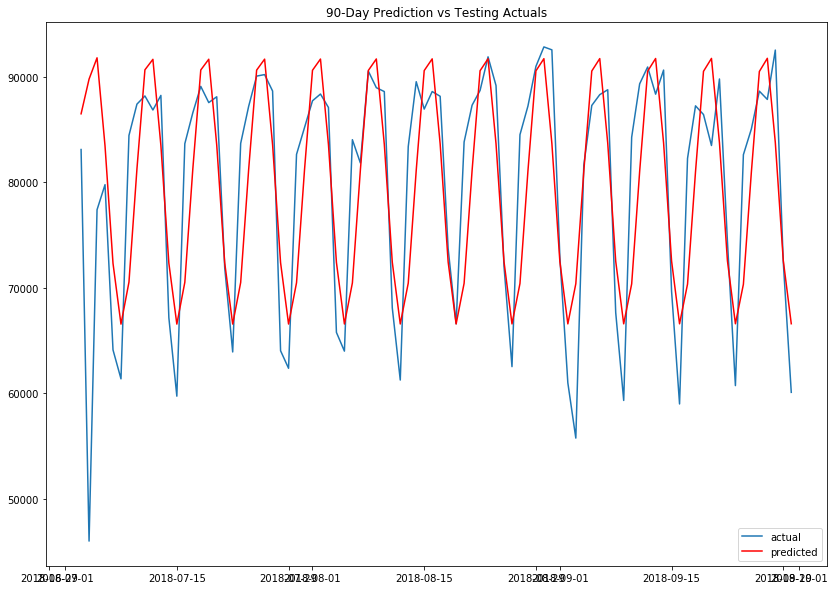

In [44]:
plot_prediction_vs_testing(test, n_steps, preds)

In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    MAPE: mean_of_all(actual/predicted*100)
    Says how close predicted values are, on average, to actuals in percentage points.
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
def get_metrics(actual, preds):
    metrics = {}
    metrics["RMSE"] = np.sqrt(mean_squared_error(actual, preds))
    metrics["MAE"] = mean_absolute_error(actual, preds)
    metrics["MAPE"] = mean_absolute_percentage_error(actual, preds)
    
    return metrics

In [47]:
def print_metrics(metrics):
    print("-- Best Model Metrics --")
    
    for metric_name, metric_value in metrics.items():
        print(metric_name, ":", metric_value)

In [48]:
metrics = get_metrics(test.values, preds)
print_metrics(metrics)

-- Best Model Metrics --
RMSE : 8128.409299194161
MAE : 5846.486435385623
MAPE : 7.917562280418139


When predicting vehicle volume 90 days in advance, I have an average error of **8128 cars** which is usually about **7.92% away from the actual daily volume of cars.**

In [49]:
def generate_forecast(data, arima_order, n_steps, data_freq):
    '''
    Train model on entire dataset then forecast 'n_steps' into the future. 
    Will not provide metric feedback since there is nothing to compare to when forecasting.
    '''
    mod = ARIMA(data, order = arima_order).fit()
    projected_vals = mod.forecast(steps=n_steps)
    
    pred_vals = projected_vals[0]  # extracts projected values
    pred_conf = projected_vals[2]  # extracts upper/lower bounds of 95% confidence interval
    forecast_dates = pd.date_range(data.index[-1], periods=n_steps, freq=data_freq)  # generates associated dates with forecasted values
    
    print("\nGenerated {}-Day Forecast using ARIMA{}".format(n_steps, arima_order))
    
    return (pred_vals, pred_conf, forecast_dates)

In [50]:
def plot_forecast(data, n_steps, pred_vals, pred_conf, forecast_dates):
    '''
    Generates plot with forecasted values and shaded 95% confidence interval region.
    '''
    plt.figure(figsize=(14,10))
    plt.fill_between(forecast_dates, pred_conf[:,0], pred_conf[:,1], color='#DCDCDC', label="95% Confidence Interval")
    plt.plot(data['2018-01-01':], label="Actual")
    plt.plot(forecast_dates, pred_vals, c='black', label="Forecasted")
    plt.title("{}-Day Forecasted Traffic Volume And 95% CI".format(n_steps))
    plt.legend()
    plt.show()


Generated 90-Day Forecast using ARIMA(3, 0, 3)


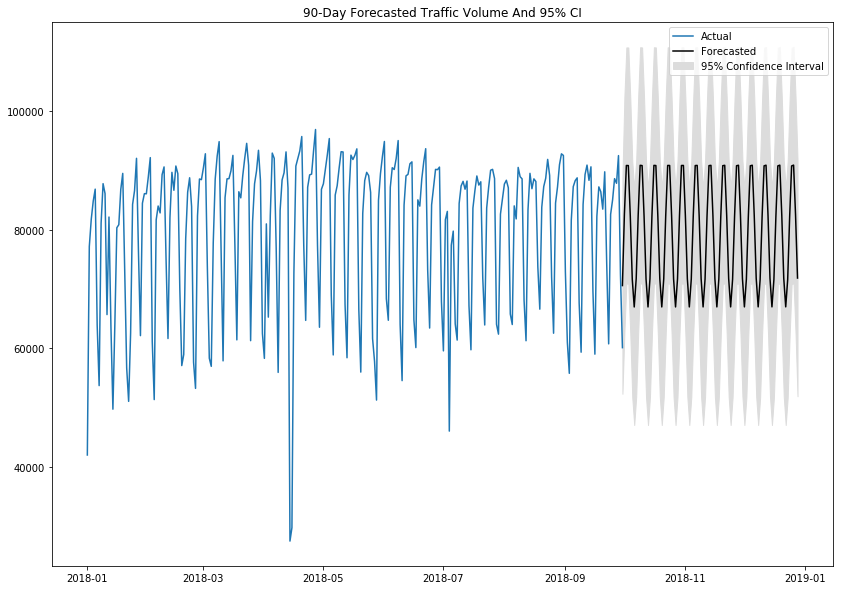

In [51]:
forecast = generate_forecast(data, auto_result.order, n_steps, "D")
plot_forecast(data, n_steps, *forecast)

## Full ARIMA Modeling

In [52]:
print("Mean Car Volume:", dfd["traffic_volume"].mean())

Mean Car Volume: 79535.24056999161


**Adjusting Forecast Window (For Daily Forecast)**

In [53]:
data = dfd  # training off daily data

In [54]:
forecast, test, preds, arima_order, metrics = traffic_volume_forecast(data, 90, "D")  # 1-quarter projection
print_metrics(metrics)

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarni


Generated 90-Day Forecast using ARIMA(3, 0, 3)
-- Best Model Metrics --
RMSE : 8128.409299194161
MAE : 5846.486435385623
MAPE : 7.917562280418139


In [55]:
# # uncomment to see visuals of the custom forecast
# plot_forecast(data, 90, forecast[0], forecast[1], forecast[2])
# plot_prediction_vs_testing(test, 90, preds)

In [56]:
forecast, test, preds, arima_order, metrics = traffic_volume_forecast(data, 180, "D")  # 2-quarter projection
print_metrics(metrics)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimiza


Generated 180-Day Forecast using ARIMA(3, 0, 3)
-- Best Model Metrics --
RMSE : 9224.310466825755
MAE : 6567.184406335943
MAPE : 9.669241479979249


In [57]:
# # uncomment to see visuals of the custom forecast
# plot_prediction_vs_testing(test, 180, preds)
# plot_forecast(data, 180, forecast[0], forecast[1], forecast[2])

In [58]:
forecast, test, preds, arima_order, metrics = traffic_volume_forecast(data, 365, "D")  # 1-year projection
print_metrics(metrics)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimiza


Generated 365-Day Forecast using ARIMA(3, 0, 3)
-- Best Model Metrics --
RMSE : 9517.34364077202
MAE : 7098.760456758164
MAPE : 10.271927036447355


In [59]:
# # uncomment to see visuals of the custom forecast
# plot_prediction_vs_testing(test, 365, preds)
# plot_forecast(data, 365, forecast[0], forecast[1], forecast[2])

**ARIMA Concluding Thoughts**

ARIMA will obviously get less acurate as you increase the window size. When I increase the forecast horizon to 1-year I get an average error of **7099 cars** per day when the mean is 79535 cars, which is approximately **10.27%** within the actual traffic volume. 

My main goal in predicting 90 days in advance got within **7.91%** of actual traffic volumes. This is still not the best result that I had in mind, so now I'll be exploring seasonal components and exogeous variables.

## SARIMAX Model

I will start by trying to predict daily car volumes 30 days in advance.

In [60]:
n_steps = 30

In [61]:
data = dfd["traffic_volume"]
train = data[:len(data)-n_steps]
test = data[len(data)-n_steps:]  

I am setting m to 7 as I found when plotting the seasonal component above.

In [62]:
auto_result = auto_arima(train, seasonal=True, m=7)

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/pmdarima/arima/_auto_solvers.py:211: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2) seasonal_order=(1, 0, 2, 7); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/pmdarima/arima/_auto_solvers.py:211: ModelFitWarning: Unable to f

In [63]:
auto_result

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 0, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 0, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [64]:
mod2 = SARIMAX(train, order=auto_result.order, seasonal_order=auto_result.seasonal_order).fit()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [65]:
preds = mod2.predict(len(train), len(train)+len(test)-1)

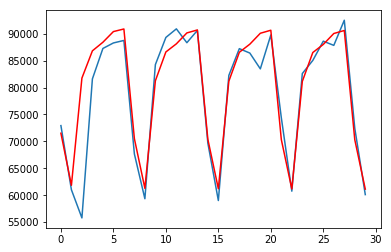

In [66]:
plt.plot(test.values)
plt.plot(preds.values, c='red')

In [67]:
metrics = get_metrics(test.values, preds)
print_metrics(metrics)

-- Best Model Metrics --
RMSE : 5305.4424561214255
MAE : 2768.717398234839
MAPE : 3.9599364019455843


In [68]:
# retraining seasonal arima with full dataset
full_mod = SARIMAX(data, order=auto_result.order, seasonal_order=auto_result.seasonal_order).fit()
forecast = full_mod.get_forecast(steps=n_steps)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [69]:
forecast_vals = forecast.predicted_mean
forecast_conf = forecast.conf_int()
forecast_dates = pd.date_range(data.index[-1], periods=n_steps, freq="D")

In [71]:
def plot_seasonal_forecast(data, n_steps, pred_vals, pred_conf, forecast_dates):
    '''
    Generates plot with forecasted values and shaded 95% confidence interval region.
    '''
    plt.figure(figsize=(14,10))
    plt.fill_between(forecast_dates, pred_conf["lower traffic_volume"], pred_conf["upper traffic_volume"], color='#DCDCDC', label="95% Confidence Interval")
    plt.plot(data['2018-01-01':], label="Actual")
    plt.plot(forecast_dates, pred_vals, c='black', label="Forecasted")
    plt.title("{}-Day Forecasted Traffic Volume And 95% CI".format(n_steps))
    plt.legend()
    plt.show()

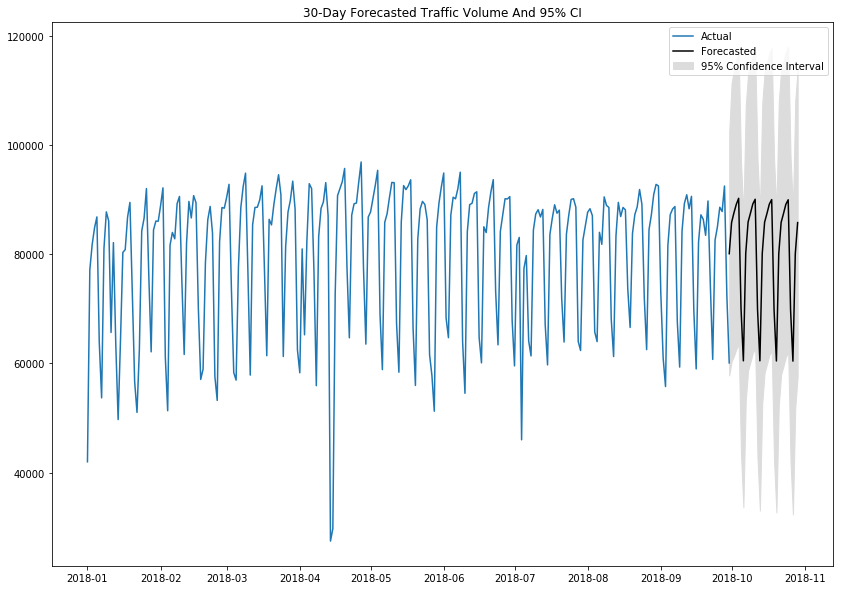

In [72]:
plot_seasonal_forecast(data, 30, forecast_vals, forecast_conf, forecast_dates)

**Reproducible SARIMAX Method**

In [73]:
def traffic_volume_seasonal_forecast(full_data, n_steps, data_freq, season_length):
    '''
    Same as 'traffic_volume_forecast' except now it considers seasonal components.
    '''
    data = full_data["traffic_volume"]
    train = data[:len(data)-n_steps]
    test = data[len(data)-n_steps:] 
    
    auto_result = auto_arima(train, seasonal=True, m=season_length)
    mod = SARIMAX(train, order=auto_result.order, seasonal_order=auto_result.seasonal_order).fit()
    
    # train/test validation
    preds = mod.predict(len(train), len(train)+len(test)-1)
    metrics = get_metrics(test.values, preds)

    # retrain model on entire dataset and get n-day forecast
    full_mod = SARIMAX(data, order=auto_result.order, seasonal_order=auto_result.seasonal_order).fit()
    forecast = full_mod.get_forecast(steps=n_steps)
    
    forecast_vals = forecast.predicted_mean
    forecast_conf = forecast.conf_int()
    forecast_dates = pd.date_range(data.index[-1], periods=n_steps, freq="D")
    
    return (forecast_vals, forecast_conf, forecast_dates), metrics

Now testing a 180 day forecast

In [75]:
warnings.filterwarnings("ignore")
forecast, metrics = traffic_volume_seasonal_forecast(dfd, 180, "D", 7)

In [76]:
print_metrics(metrics)

-- Best Model Metrics --
RMSE : 7359.478563060571
MAE : 5164.605166964693
MAPE : 7.602105920506739


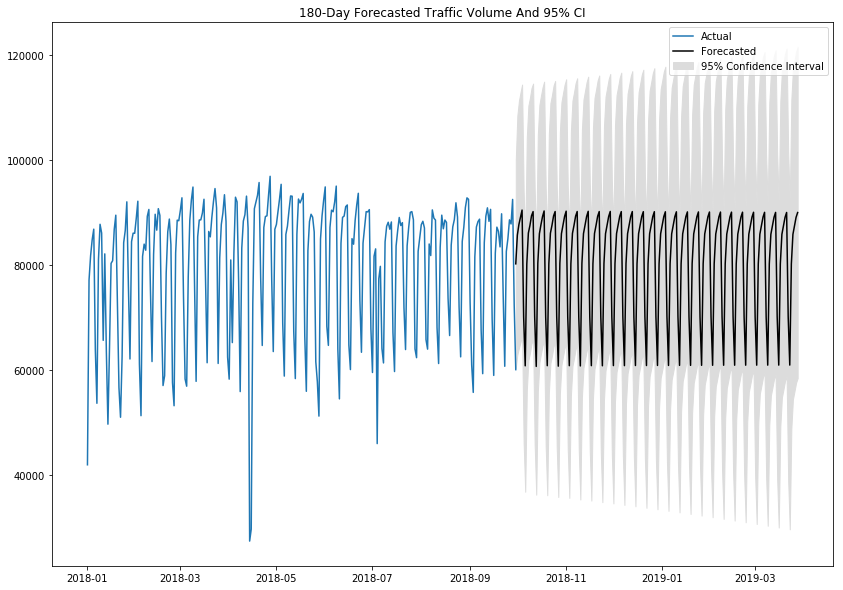

In [77]:
plot_seasonal_forecast(data, 180, *forecast)

Now testing a 365 day (1 year) forecast

In [78]:
warnings.filterwarnings("ignore")
forecast, metrics = traffic_volume_seasonal_forecast(dfd, 365, "D", 7)

In [79]:
print_metrics(metrics)

-- Best Model Metrics --
RMSE : 8842.812415599783
MAE : 5036.433915174212
MAPE : 8.08695685561477


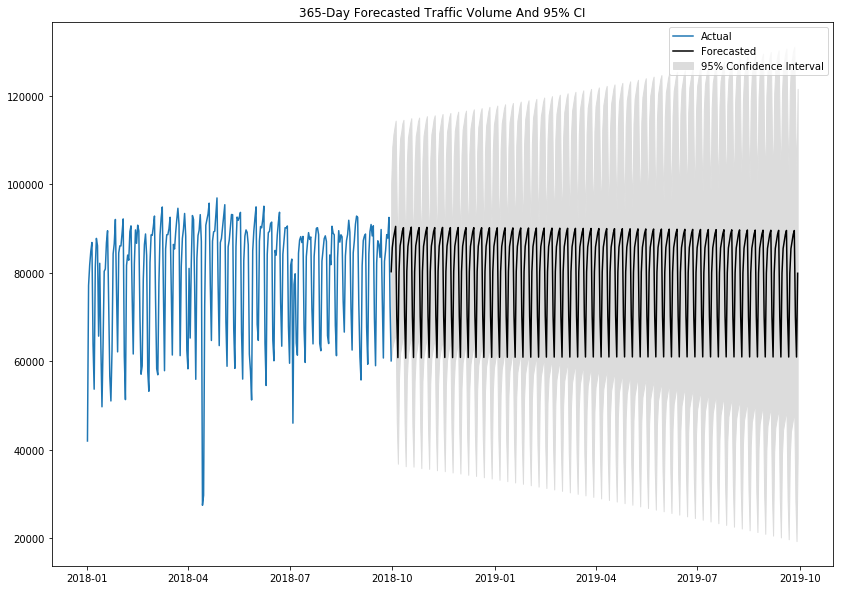

In [80]:
plot_seasonal_forecast(data, 365, *forecast)

These forecasts look much better than just the ARIMA model. However, I still want to capture "irregular" days. Days that have sharp decreases or sharp increases. This would dramatically reduce RMSE which penalizes the model harshly for large discrepancies as opposed to smaller ones. For this, I will try inducing exogenous variables. 

## Adding Exogenous Variables (SARIMAX)

**Feature Engineering**

In order to introduce exogenous variables to the model, I am going to do a bit of feature engineering so that I can include whether a day is a holiday or rainy as opposed to sunny. These factors likely influence whether a driver decides to go on the freeway. 

Encoded holidays with binary value. Also going to perform one-hot encoding for both weather_main and weather_description attributes.

In [81]:
dfd["holiday"].unique()

array([0., 1., 2., 3.])

In [82]:
dfd["holiday"] = dfd["holiday"].apply(lambda x: 1 if x >= 1 else 0)
dfd["holiday"].unique()

array([0, 1])

Going to now encode the recorded weather in numerical strings to try and capture the mix of weather each day.

In [83]:
df["weather_main"].unique()

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Fog',
       'Thunderstorm', 'Snow', 'Squall', 'Smoke'], dtype=object)

In [84]:
print("{} unique weather patterns.".format(len(dfd["weather_main"].unique())))

1137 unique weather patterns.


In [85]:
weather_codes = {
    'Clouds': '1',
    'Clear': '2',
    'Rain': '3',
    'Drizzle': '4',
    'Mist': '5',
    'Haze': '6',
    'Fog': '6',
    'Thunderstorm': '7',
    'Snow': '8',
    'Squall': '9',
    'Smoke': '6'
}
# treating haze, fog, and smooke as the same weather condition

In [86]:
pd.get_dummies(dfd["weather_main"]).shape

(1193, 1137)

In [87]:
all_encoded_weather_patterns = []
for weather_pattern in dfd["weather_main"]:
    encoded_weather_pattern = ""
    for weather_obs in weather_pattern.split(", "):
        encoded_weather_pattern += weather_codes[weather_obs]
    
    all_encoded_weather_patterns.append(encoded_weather_pattern)

dfd["weather_pattern"] = all_encoded_weather_patterns

In [88]:
dfd["weather_pattern"] = dfd["weather_pattern"].astype(float)

**Training SARIMAX on seasonal and exogeneous weather and holiday data**

In [89]:
data = dfd[["traffic_volume", "holiday", "weather_pattern"]]
train = data[:len(data)-n_steps]
test = data[len(data)-n_steps:] 

In [90]:
warnings.filterwarnings("ignore")
auto_result = auto_arima(train["traffic_volume"], exog = train[["weather_pattern"]], seasonal=True, m=7)

In [91]:
auto_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1163
Model:             SARIMAX(2, 0, 3)x(2, 0, 1, 7)   Log Likelihood              -12166.689
Date:                           Sun, 06 Oct 2019   AIC                          24353.379
Time:                                   22:56:39   BIC                          24403.966
Sample:                                        0   HQIC                         24372.464
                                          - 1163                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.652e+04   1.26e+04      4.471      0.000    3.17e+04    8.13e+04
ar.L1         -1.9134      0.028    -67.890      0.000      -1.969      -1.858
ar.L2         -0.9810      0.028    -35.291      0.000      -1.035      -0.927
ma.L1          2.3989      0.038     63.414      0.000       2.325       2.473
ma.L2          1.9206      0.060     31.818      0.000       1.802       2.039
ma.L3          0.4866      0.027     17.829      0.000       0.433       0.540
ar.S.L7        0.6583      0.085      7.729      0.000       0.491       0.825
ar.S.L14       0.1620      0.053      3.084      0.002       0.059       0.265
ma.S.L7       -0.3837      0.084     -4.586      0.000      -0.548      -0.220
sigma2      9.892e+07      8.823   1.12e+07      0.000    9.89e+07    9.89e+07
===================================================================================
Ljung-Box (Q):                      156.54   Jarque-Bera (JB):              4961.16
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.38e+26. Standard errors may be unstable.
"""

In [92]:
warnings.filterwarnings("ignore")
mod = SARIMAX(train["traffic_volume"], exog = train[["weather_pattern"]], order=auto_result.order, seasonal_order=auto_result.seasonal_order).fit()

In [93]:
preds = mod.predict(len(train), len(train)+len(test)-1, exog=test[["weather_pattern"]])

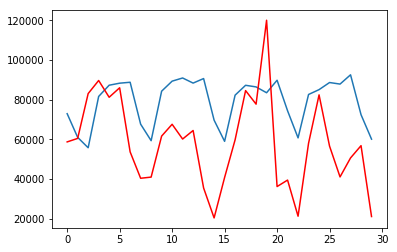

In [94]:
plt.plot(test["traffic_volume"].values)
plt.plot(preds.values, c='red')

In [95]:
get_metrics(test["traffic_volume"], preds.values)

{'RMSE': 29753.83300561061,
 'MAE': 25378.370480150297,
 'MAPE': 32.777291511675735}

The model when adding in weather as an exogenous variable falls apart. This may be due to mixed signals as to the volume of cars traveling on certain weather days. 

**Exploratory Weather Analysis**

In [96]:
clear_hours = dfh[dfh["weather_main"] == "Clear"]
clear_day_hourly_avgs = clear_hours.groupby(clear_hours.index.hour).mean()

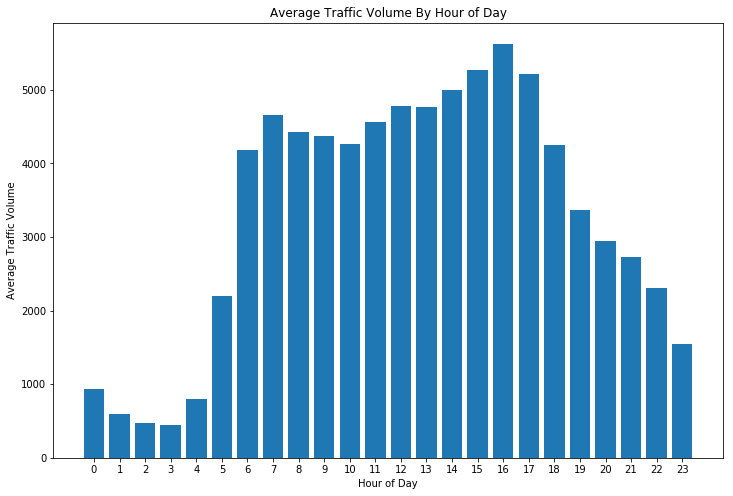

In [97]:
plt.figure(figsize=(12,8))
plt.bar(clear_day_hourly_avgs.index, clear_day_hourly_avgs["traffic_volume"])
plt.xticks([hour for hour in range(24)])
plt.title("Average Traffic Volume By Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Traffic Volume");

In [98]:
not_clear_hours = dfh[dfh["weather_main"] == "Rain"]
not_clear_day_hourly_avgs = not_clear_hours.groupby(not_clear_hours.index.hour).mean()

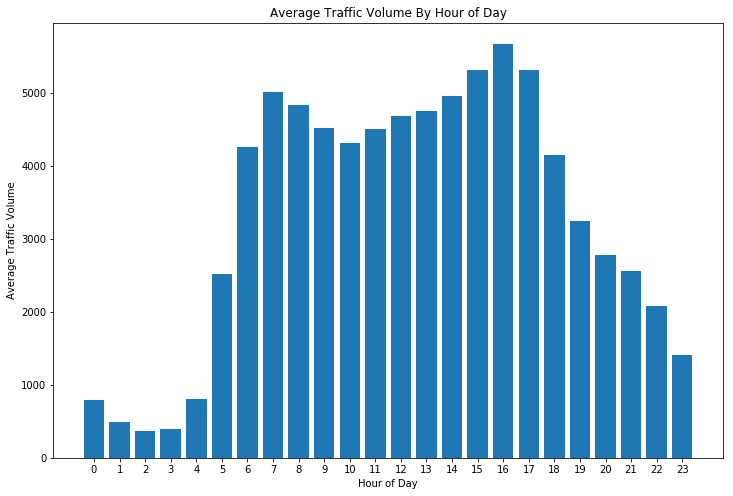

In [99]:
plt.figure(figsize=(12,8))
plt.bar(not_clear_day_hourly_avgs.index, not_clear_day_hourly_avgs["traffic_volume"])
plt.xticks([hour for hour in range(24)])
plt.title("Average Traffic Volume By Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Traffic Volume");

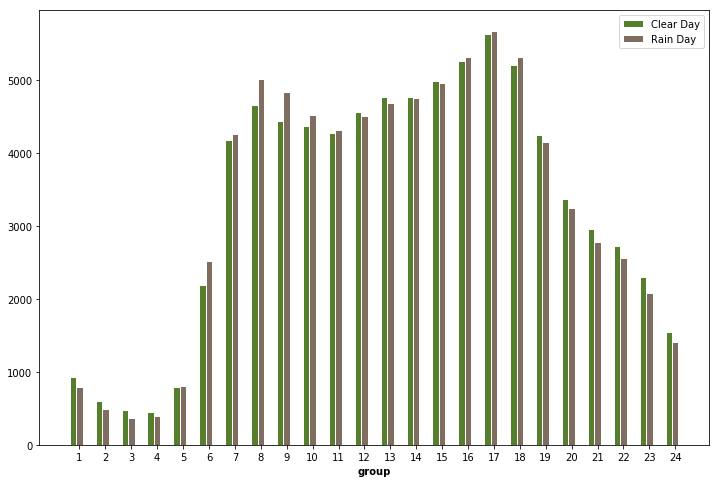

In [100]:
plt.figure(figsize=(12,8))
barWidth = 0.25
 
# set height of bar
bars1 = clear_day_hourly_avgs["traffic_volume"]
bars2 = not_clear_day_hourly_avgs["traffic_volume"]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#557f2d', width=barWidth, edgecolor='white', label='Clear Day')
plt.bar(r2, bars2, color='#7f6d5f', width=barWidth, edgecolor='white', label='Rain Day')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [i for i in range(1, 25)])
 
# Create legend & Show graphic
plt.legend()
plt.show()

On days of extreme weather, there are differences in the volumes but they are not as extreme, so it muddles the model. Thus, I would go with the SARIMA/ARIMA seasonal model since I was getting within 7% of the actual traffic volumes.

### Final SARIMA Model (1 year horizon)

In [101]:
warnings.filterwarnings("ignore")
forecast, metrics = traffic_volume_seasonal_forecast(dfd, 365, "D", 7)

In [102]:
print_metrics(metrics)

-- Best Model Metrics --
RMSE : 8842.812415599783
MAE : 5036.433915174212
MAPE : 8.08695685561477


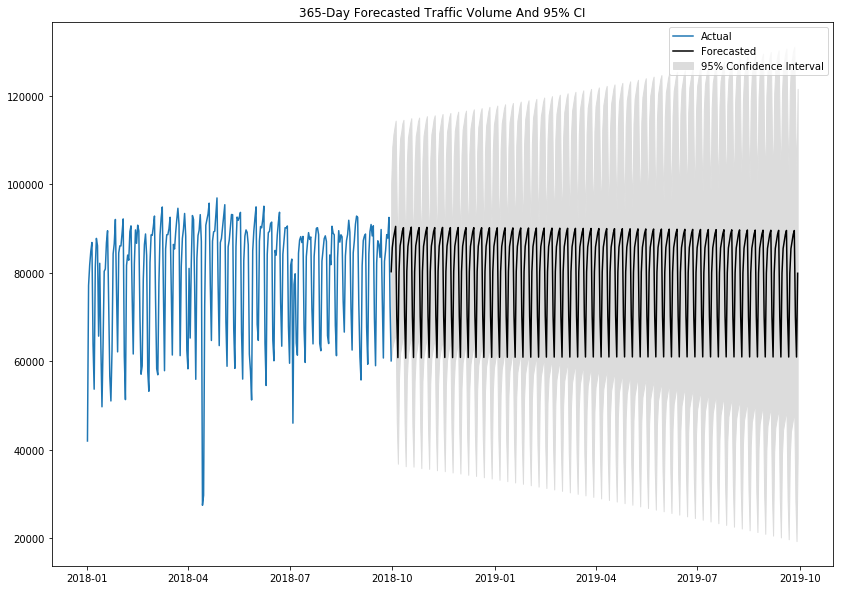

In [103]:
data = dfd["traffic_volume"]
plot_seasonal_forecast(data, 365, *forecast)